### Count regression

This notebook demonstrates the use of tfp for regression on count data on a simple data set. 

* Poisson Regression
* Zero Infated Poisson Regression

#### Links:
Using plain TF
https://github.com/gokceneraslan/neuralnet_countmodels/blob/master/Count%20models%20with%20neuralnets.ipynb


.

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install tfp-nightly
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


### Creating some count data

2.0
1.4142135


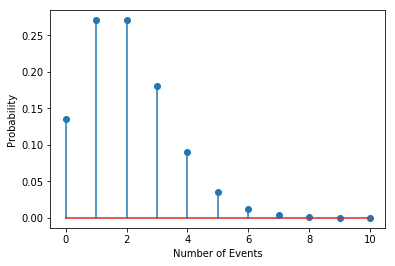

In [3]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
dist = tfd.poisson.Poisson(rate = 2) #A
vals = np.linspace(0,10,11) #B
p = dist.prob(vals) #C
print(dist.mean().numpy())  #D
print(dist.stddev().numpy())   #E

plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.savefig('ch05_rain.pdf')

#A Poisson distribution with parameter rate 2
#B some values for the x-axis in figure 5.rain
#C the probability for the values
#D the mean value yielding 2.0
#E the standard deviation yielding sqrt(2.0) = 1.41...

## Loading some count data

We use some traditional count data from: https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta see also: https://stats.idre.ucla.edu/r/dae/negative-binomial-regression/ 

In [4]:
d = np.loadtxt('../data/nb_data.csv') #TODO make availible with blog like link
X = d[...,0:3]
y = d[...,4]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((210, 3), (210,), (104, 3), (104,))

In [5]:
y.shape, X.shape, X[0:5,]

((314,), (314, 3), array([[63.,  1.,  0.],
        [27.,  1.,  0.],
        [20.,  1.,  0.],
        [16.,  1.,  0.],
        [ 2.,  1.,  0.]]))

(5.390476190476191, 39.714195011337864)

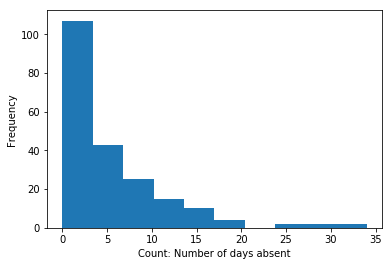

In [22]:
plt.hist(y_tr)
plt.xlabel('Count: Number of days absent')
plt.ylabel('Frequency')
plt.savefig('ch05_school.pdf')
np.mean(y_tr), np.var(y_tr)

## 1 Doing linear regression

In [7]:
model_lr = tf.keras.Sequential() #A
model_lr.add(tf.keras.layers.Dense(1,input_dim=3, activation='linear')) #B 
model_lr.compile(loss='mean_squared_error',optimizer=tf.optimizers.Adam(learning_rate=0.01))

In [8]:
hist_lr = model_lr.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=600, verbose=False);

42.59290604504328

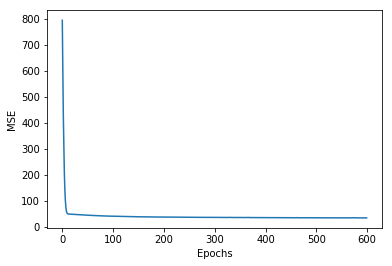

In [9]:
plt.plot(hist_lr.history['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
np.mean(hist_lr.history['loss'])

In [10]:
y_hat_te = model_lr.predict(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.sqrt(np.mean(np.abs((y_hat_te - y_te))))

(8.488157449435617, 2.4476286052833736)

## 2 Doing Poisson Regression

#### Definition of the Model

$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [17]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
inputs = tf.keras.layers.Input(shape=(X_tr.shape[1],))  
rate = tf.keras.layers.Dense(1, 
         activation=tf.exp, #A
         bias_initializer='zeros', 
         kernel_initializer='zeros')(inputs)
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 

model_p = Model(inputs=inputs, outputs=p_y) #C


def negloglik(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(tf.optimizers.Adam(learning_rate=0.01), 
                loss=negloglik)

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing input and output together. Note that output is a tf.distribution
#D Since the second argument is the output of the model it is a distribution. It's as simple as calling log_prob to calculate the NLL.



In [18]:
hist_p = model_p.fit(x=X_tr, y=y_tr, validation_data=(X_te, y_te), epochs=600, verbose=False);

4.170110304079358

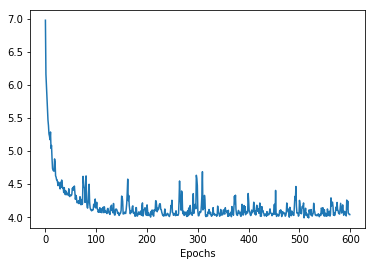

In [19]:
plt.plot(hist_p.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
np.mean(hist_p.history['loss'])

In [20]:
model_pm = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) 
y_hat_te = model_pm(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.sqrt(np.mean(np.abs((y_hat_te - y_te))))

(8.627583, 2.4648361)

## 3 Using zero inflated poisson

We define a network with two outputs. One for the poisson mean, one for the prob that there is a zero. 

First, we define a function which produces the zero inflated poisson distribution. 

In [23]:
## Definition of the custom parametrized distribution
def my_zero(t):
    mean = tf.exp(t[:,0]) #Needed so that Poisson has batch_shape=(5,) 
    #print(mean)
    s = tf.math.sigmoid(t[...,1:])
    probs = tf.concat([s, 1-s], axis=1)
    #print(probs)
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#batch_shape=(5,) event_shape=()
          components=[
            tfd.Poisson(rate=mean),   #batch_shape=(5,) event_shape=()
            #tfd.Poisson(rate=0.00001*mean), #Hack to produce 0
            tfd.Deterministic(loc=tf.zeros_like(mean))
        ])

In [24]:
## testinging the distribution
t = np.ones((5,2), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
print(t)
my_zero(t).mean(), tfd.Poisson(tf.exp(1.0)).mean()

W0606 17:22:22.527987 140308744468224 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


[[ 1.     1.   ]
 [ 1.     1.   ]
 [ 1.     1.   ]
 [ 1.     1.   ]
 [ 0.999 10.   ]]


(<tf.Tensor: id=113338, shape=(5,), dtype=float32, numpy=
 array([1.9872233, 1.9872233, 1.9872233, 1.9872233, 2.7154417],
       dtype=float32)>,
 <tf.Tensor: id=113340, shape=(), dtype=float32, numpy=2.7182817>)

In [25]:
## Definition of the model
inputs = tf.keras.layers.Input(shape=(3,))
mean_logit = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(inputs)
p_zero_logit = tf.keras.layers.Dense(1,bias_initializer='zeros', kernel_initializer='zeros')(inputs)

# Combining the path
tt = tf.concat([mean_logit, p_zero_logit], axis=1)
p_y_nb = tfp.layers.DistributionLambda(my_zero)(tt)

#Glueing input and output together. Note that output is a tf.distirbution 
model_zi = tf.keras.models.Model(inputs=inputs, outputs=p_y_nb)
model_zi.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            4           input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            4           input_3[0][0]                    
__________________________________________________________________________________________________
concat (TensorFlowOpLayer)      [(None, 2)]          0           dense_3[0][0]                    
                                                                 dense_4[0][0]              

In [26]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

model_zi.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
hist_zi = model_zi.fit(X, y, epochs=1200, verbose=False);

3.8214371433227687

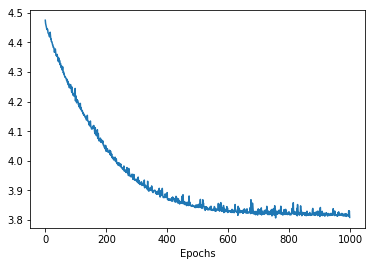

In [27]:
plt.plot(hist_zi.history['loss'][200:])
plt.xlabel('Epochs')
np.mean(hist_zi.history['loss'][1000:]) 

In [28]:
model_zi = tf.keras.models.Model(inputs=inputs, outputs=p_y_nb)
y_hat_te = model_zi(X_te)
np.sqrt(np.mean((y_hat_te - y_te)**2)),np.sqrt(np.mean(np.abs((y_hat_te - y_te))))

(8.50848, 2.4119096)